In [1]:
%load_ext autoreload
%autoreload 2

## Lipophilicity benchmark

Let's evaluate the effectiveness of the LLM representations against some commonly used representations in Molecular Modelling. 

We will follow the same setup as the [molfeat benchmark](https://molfeat-docs.datamol.io/stable/benchmark.html). However, it should be noted that this is not an exhaustive benchmark, and therefore the results should be interpreted with caution.

The molfeat benchmark employed the following representations: **ECFP6**, **Mordred**, and **ChemBERTa**. To ensure consistency, we will use these same representations and their results.

Since LLMs are computationally expensive, we will limit our evaluation to the _Lipophilicity_ benchmark.

For our experiments, we will consider the following featurizers:

- **openai/text-embedding-ada-002**: the default OpenAI embedding model.
- **sentence-transformers/all-mpnet-base-v2**: a popular [sentence embedding model](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) that maps text into a 768-dimensional dense vector.
- **openai/gpt-3.5-turbo**: OpenAI's instruction-following model that powers ChatGPT.
- **hkunlp/instructor-large**: an [instruction-conditioned model](https://huggingface.co/hkunlp/instructor-large) for embedding generation.

<div class="admonition tip highlight">
<p class="admonition-title">Tl;dr - Can non-finetuned LLMs outperform hand-crafted or pretrained molecular featurizers?</p>
<p>
<strong>No.</strong> Understanding molecular context, structure, and properties is essential for building effective molecular featurizers. However, while it is crucial to comprehend the molecular structure, non-finetuned LLMs still show potential for molecular search.
</p>
</div>

```bash
! pip install auto-sklearn
````

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import datamol as dm

import matplotlib.pyplot as plt
import autosklearn.classification
import autosklearn.regression
from tqdm.auto import tqdm
from collections import defaultdict
from rdkit.Chem import SaltRemover

from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

from molfeat.utils.cache import FileCache
from molfeat.trans.base import PrecomputedMolTransformer
from molfeat.trans.fp import FPVecTransformer
from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer
from molfeat_hype.trans.llm_embeddings import LLMTransformer
from molfeat_hype.trans.llm_instruct_embeddings import InstructLLMTransformer

/Users/manu/.miniconda/envs/molfeat_hype/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Making the output less verbose
warnings.simplefilter("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
dm.disable_rdkit_log()

In [4]:
def load_dataset(uri: str, readout_col: str):
    """Loads the MoleculeNet dataset"""
    df = pd.read_csv(uri)
    smiles = df["smiles"].values
    y = df[readout_col].values
    return smiles, y


def preprocess_smiles(smi):
    """Preprocesses the SMILES string"""
    mol = dm.to_mol(smi, ordered=True, sanitize=False)    
    try: 
        mol = dm.sanitize_mol(mol)
    except:
        mol = None
            
    if mol is None: 
        return
        
    mol = dm.standardize_mol(mol, disconnect_metals=True)
    remover = SaltRemover.SaltRemover()
    mol = remover.StripMol(mol, dontRemoveEverything=True)

    return dm.to_smiles(mol)


def scaffold_split(smiles):
    """In line with common practice, we will use the scaffold split to evaluate our models"""
    scaffolds = [dm.to_smiles(dm.to_scaffold_murcko(dm.to_mol(smi))) for smi in smiles]
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    return next(splitter.split(smiles, groups=scaffolds))


Classic embeddings

In [5]:
openai_api_key = os.environ.get("OPENAI_API_KEY", None)

In [6]:
! mkdir -p ../../cache/

In [7]:
openai_ada_cache = FileCache(cache_file="../../cache/openai_ada_cache.parquet", name="openai_ada_cache")
transf_openai_ada = LLMTransformer(kind="openai/text-embedding-ada-002", openai_api_key=openai_api_key, precompute_cache=openai_ada_cache)

In [8]:
sent_trans_cache = FileCache(cache_file="../../cache/sentence_transformer.parquet", name="sent_trans_cache")
transf_sentence = LLMTransformer(kind="sentence-transformers/all-mpnet-base-v2", precompute_cache=sent_trans_cache)

Instruct embeddings

In [9]:
cond_embed_cache = FileCache(cache_file="../../cache/cond_embed.parquet", name="cond_embed_cache")
transf_cond_embed = InstructLLMTransformer(kind="hkunlp/instructor-large", precompute_cache=cond_embed_cache)

load INSTRUCTOR_Transformer
max_seq_length  512


#### Lipophilicity
Lipophilicity is a regression task with 4200 molecules

In [10]:
# Prepare the Lipophilicity dataset
smiles, y_true = load_dataset("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv", "exp")

smiles = np.array([preprocess_smiles(smi) for smi in smiles])
smiles = np.array([smi for smi in smiles if dm.to_mol(smi) is not None])

feats_openai_ada, ind_openai_ada = transf_openai_ada(smiles, ignore_errors=True)

X = {
    "openai/text-embedding-ada-002": feats_openai_ada[ind_openai_ada],
}

In [11]:
feats_sentence, ind_sentence = transf_sentence(smiles, ignore_errors=True)
X["sentence-transformers/all-mpnet-base-v2"] = feats_sentence[ind_sentence]

In [12]:
# feats_cond_embed = transf_cond_embed.batch_transform(transf_cond_embed, smiles, batch_size=512, n_jobs=8, progress=True)
# ind_cond_embed = np.arange(len(smiles))
# X["hkunlp/instructor-large"] = feats_cond_embed[ind_cond_embed]

In [13]:
# mols = [dm.to_mol(smi) for smi in smiles]
# _cache = dict(zip(mols, feats_cond_embed))
# transf_cond_embed.precompute_cache.update(_cache)

In [14]:
feats_cond_embed, ind_cond_embed = transf_cond_embed(smiles, ignore_errors=True)
X["hkunlp/instructor-large"] = feats_cond_embed[ind_cond_embed]

In [15]:
# transf_base_chatgpt = InstructLLMTransformer(kind="openai/chatgpt", embedding_size=16, openai_api_key=openai_api_key, precompute_cache=False, conv_buffer_size=4, request_timeout=300)
# transf_chatgpt = PrecomputedMolTransformer(cache=chatgpt_cache, featurizer=transf_base_chatgpt)
#feats_chatgpt = transf_chatgpt.batch_transform(transf_chatgpt, smiles, batch_size=16, n_jobs=-1)
#X["openai/chatgpt"] = feats_chatgpt[ind_chatgpt]
# chatgpt_cache.update(transf_chatgpt.cache)
# chatgpt_cache.save_to_file()

In [16]:
chatgpt_cache = FileCache(cache_file="../../cache/chatgpt.parquet", name="chatgpt_cache")
transf_chatgpt = InstructLLMTransformer(kind="openai/chatgpt", embedding_size=16, openai_api_key=openai_api_key, conv_buffer_size=3, request_timeout=300, precompute_cache=chatgpt_cache, batch_size=4)

In [17]:
# for k, x in transf_chatgpt.precompute_cache.cache.copy().items():
#     if x is None  or np.any(np.isnan(x)):
#         del transf_chatgpt.precompute_cache.cache[k]

In [18]:
feats_chatgpt, ind_chatgpt = transf_chatgpt(smiles, ignore_errors=True)
X["openai/chatgpt"] = feats_chatgpt#[ind_chatgpt]

In [19]:
# transf_sentence.precompute_cache.save_to_file()
# transf_openai_ada.precompute_cache.save_to_file()
# transf_cond_embed.precompute_cache.save_to_file()
# transf_chatgpt.precompute_cache.save_to_file()

In [20]:
# Train a model
train_ind, test_ind = scaffold_split(smiles)

lipo_scores = {}
for name, feats in tqdm(X.items()):
    # print(name, feats.shape, y_true.shape, np.any(np.isnan(feats)))
    # Train
    automl = autosklearn.regression.AutoSklearnRegressor(
        memory_limit=None, 
        # For practicality’s sake, limit this to 5 minutes! 
        # (x3 = 15 min in total)
        time_left_for_this_task=360,  
        n_jobs=-1,
        seed=1,
    )
    automl.fit(feats[train_ind], y_true[train_ind])
    
    
    # Predict and evaluate
    y_hat = automl.predict(feats[test_ind])
    
    # Evaluate
    mae = mean_absolute_error(y_true[test_ind], y_hat)
    lipo_scores[name] = mae

lipo_scores

  0%|          | 0/4 [00:00<?, ?it/s]

[WARNING] [2023-05-04 13:13:47,343:Client-AutoML(1):ffcb4af8-ea9e-11ed-b288-acde48001122] Capping the per_run_time_limit to 178.0 to have time for a least 2 models in each process.


 25%|██▌       | 1/4 [06:18<18:54, 378.18s/it]

[WARNING] [2023-05-04 13:19:55,515:Client-AutoML(1):e158faba-ea9f-11ed-b288-acde48001122] Capping the per_run_time_limit to 178.0 to have time for a least 2 models in each process.


 50%|█████     | 2/4 [12:18<12:15, 367.70s/it]

[WARNING] [2023-05-04 13:25:54,854:Client-AutoML(1):b80fdbaa-eaa0-11ed-b288-acde48001122] Capping the per_run_time_limit to 178.0 to have time for a least 2 models in each process.


 75%|███████▌  | 3/4 [18:19<06:04, 364.73s/it]

[WARNING] [2023-05-04 13:31:55,652:Client-AutoML(1):8f2c8d7c-eaa1-11ed-b288-acde48001122] Capping the per_run_time_limit to 178.0 to have time for a least 2 models in each process.
[WARNING] [2023-05-04 13:32:16,838:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-05-04 13:32:23,216:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-05-04 13:32:23,664:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-05-04 13:32:31,623:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-05-04 13:32:37,678:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy

100%|██████████| 4/4 [24:56<00:00, 374.17s/it]


{'openai/text-embedding-ada-002': 0.8497511191899347,
 'sentence-transformers/all-mpnet-base-v2': 0.846618632301065,
 'hkunlp/instructor-large': 0.8109557972763406,
 'openai/chatgpt': 0.9247671337879687}

In [22]:
## Let's use a random baseline predicting the mean/median of the dataset

from sklearn.dummy import DummyRegressor
random_dummy_regr = DummyRegressor(strategy="mean")
random_dummy_regr.fit(feats[train_ind], y_true[train_ind])
y_random_pred = random_dummy_regr.predict(feats[test_ind])
mae = mean_absolute_error(y_true[test_ind], y_random_pred)
lipo_scores["dummy"] = mae
mae

0.9226949930564216

#### Conclusion

| Dataset       | Metric   | Representation | Score | Rank |
|---------------|----------|----------------|-------|------|
|Lipophilicity   |  MAE ↓  | Mordred        | 0.579  | 0    |
|               |           | ECFP           | 0.727  | 1    |
|               |          | ChemBERTa      | 0.740  | 2    |
|               |          | hkunlp/instructor-large      | 0.811  | 3    |
|               |          | sentence-transformers/all-mpnet-base-v2      | 0.847  | 4    |
|               |          | openai/text-embedding-ada-002      | 0.850  | 5    |
|               |          | <span style="color:red">Dummy (mean)</span>       | 0.922  | 6    |
|               |          | openai/chatgpt      | 0.924  | 7    |



As expected, the molecular structure/context/properties aware featurizers, such as `ECFP6`, `Mordred` and `ChemBERTa`, outperformed the models built with non-finetuned LLM embeddings. Some of the LLM-based models even performed worse than what you would expect from a random models predicting the average of the output distribution. However, it is worth noting that the instruction-conditioned model, `hkunlp/instructor-large`, performed reasonably well, while `ChatGPT` had the lowest performance among all the models tested.

----

## Investigating similarity search 

Ok, so LLMs are not very good for modelling, but how good are they for  analogs search ?

In [50]:
from scipy.spatial import distance

In [19]:
# Setup the featurizers
trans_ecfp = FPVecTransformer(kind="ecfp:6", n_jobs=-1)
trans_chemberta = PretrainedHFTransformer(kind='ChemBERTa-77M-MLM', notation='smiles')

In [21]:
ecfp_embeddings = trans_ecfp(smiles)
chemberta_embeddings = trans_chemberta.batch_transform(trans_chemberta, smiles, concatenate=True, batch_size=128)

In [27]:
ecfp_mat = distance.pdist(ecfp_embeddings, metric="cosine")
chemberta_mat = distance.pdist(chemberta_embeddings, metric="cosine")
chatgpt_mat = distance.pdist(X["openai/chatgpt"], metric="cosine")
st_mat = distance.pdist(X["sentence-transformers/all-mpnet-base-v2"], metric="cosine")
openai_mat = distance.pdist(X["openai/text-embedding-ada-002"], metric="cosine")
instruct_mat = distance.pdist(X["hkunlp/instructor-large"], metric="cosine")

In [30]:
# transform into square matrix
ecfp_square_mat = distance.squareform(ecfp_mat)
chatgpt_square_mat = distance.squareform(chatgpt_mat)
chemberta_square_mat = distance.squareform(chemberta_mat)
st_square_mat = distance.squareform(st_mat)
openai_square_mat = distance.squareform(openai_mat)
instruct_square_mat = distance.squareform(instruct_mat)

In [57]:
def plot_mol_analogs(mol_ind=1):
    ecfp_selection = np.argsort(ecfp_square_mat, axis=-1)[:, :5][mol_ind]
    chatgpt_selection = np.argsort(chatgpt_square_mat, axis=-1)[:, :5][mol_ind]
    chemberta_selection = np.argsort(chemberta_square_mat, axis=-1)[:, :5][mol_ind]
    st_selection = np.argsort(st_square_mat, axis=-1)[:, :5][mol_ind]
    openai_selection = np.argsort(openai_square_mat, axis=-1)[:, :5][mol_ind]
    instruct_selection = np.argsort(instruct_square_mat, axis=-1)[:, :5][mol_ind]
    out = dm.to_image(
        [dm.to_mol(smiles[i]) for i in ecfp_selection]+
        [dm.to_mol(smiles[i]) for i in chemberta_selection]+
        [dm.to_mol(smiles[i]) for i in st_selection]+
        [dm.to_mol(smiles[i]) for i in openai_selection]+
        [dm.to_mol(smiles[i]) for i in chatgpt_selection]+
        [dm.to_mol(smiles[i]) for i in instruct_selection],
        legends=["Query"]+["ECFP6"]*4+["Query"]+["ChemBERTa"]*4+["Query"]+["Sentence Transformers"]*4+["Query"]+["OpenAI-Embeddings"]*4 +["Query"]+["ChatGPT"]*4+["Query"]+["Instructor"]*4,
        n_cols=5,
        mol_size=(200, 200),
        )
    return out

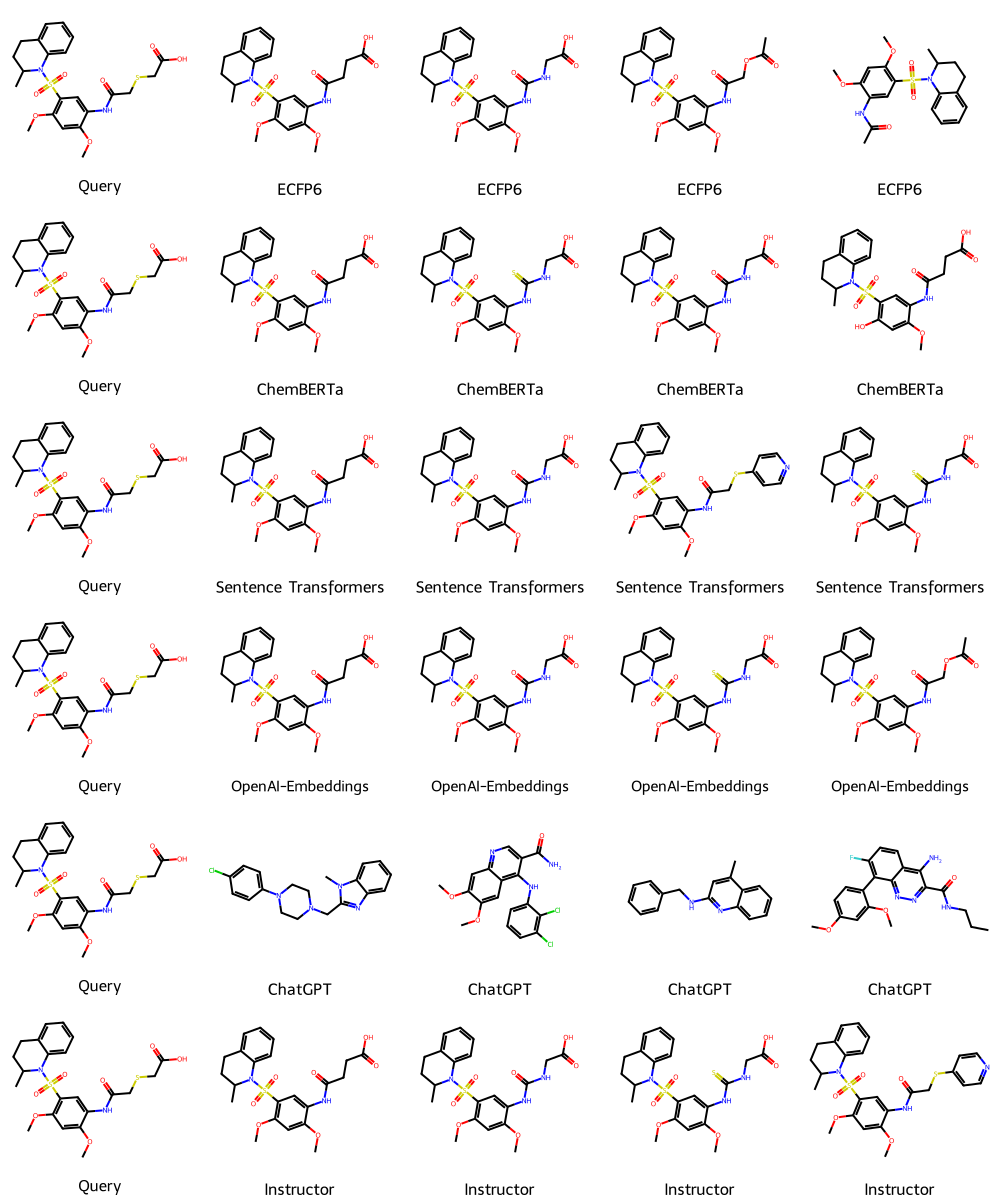

In [58]:
plot_mol_analogs(1)

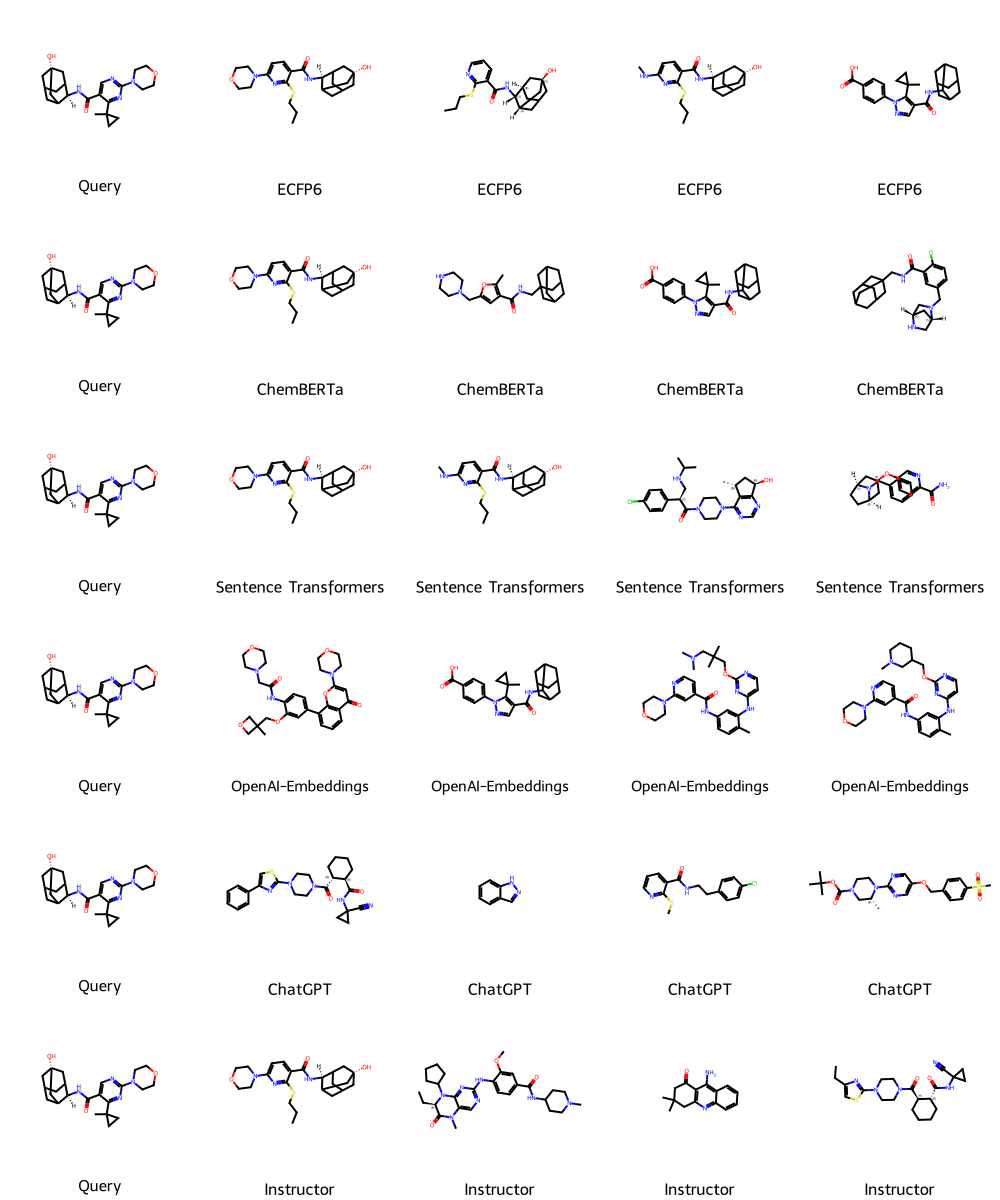

In [59]:
plot_mol_analogs(80)

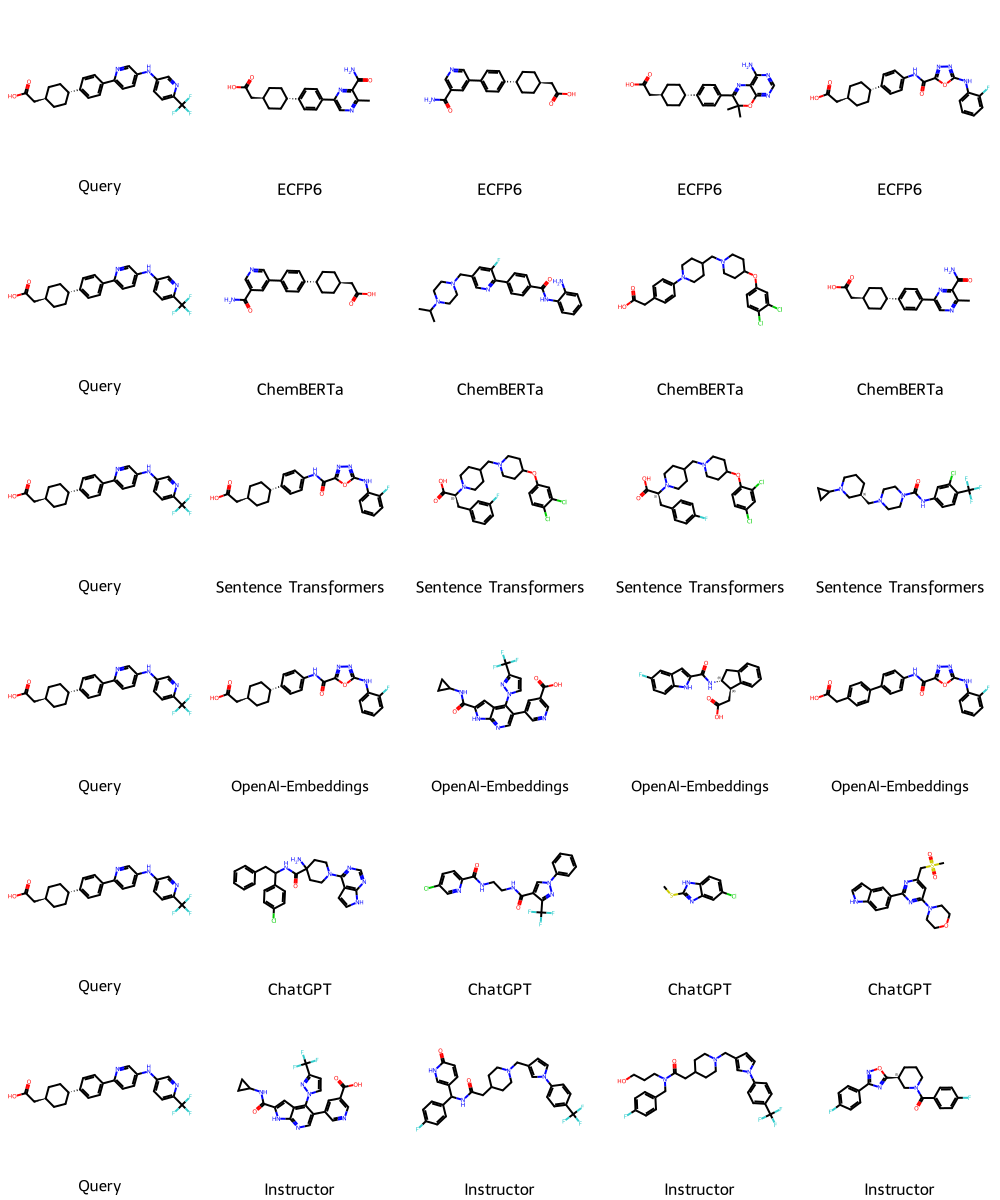

In [60]:
plot_mol_analogs(3500)

#### Conclusion

The results are slightly surprising. Except for ChatGPT who struggles a lot, most LLMs, embeddings are able to capture "some" molecular context and could be interesting to explore for `scaffold hopping` for example.

On ChatGPT, maybe improving the prompt could help. 